<a href="https://colab.research.google.com/github/Shakil-1501/TSAI/blob/master/S11/S11_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

In [ ]:
torch.__version__

'1.5.0+cu101'

In [16]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 11.0 GB  | Proc size: 2.9 GB
GPU RAM Free: 10613MB | Used: 5667MB | Util  35% | Total 16280MB


In [2]:
!nvidia-smi

Sat Jun 20 09:11:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from albumentations import Compose, Normalize, HorizontalFlip, VerticalFlip, Resize,Rotate , Cutout
from albumentations.pytorch import ToTensor
import numpy as np
import imgaug.augmenters as iaa
import torch.optim as optim
import time
import matplotlib.pyplot as plt

In [18]:
!git clone https://github.com/Shakil-1501/TSAI.git

fatal: destination path 'TSAI' already exists and is not an empty directory.


In [19]:
from TSAI.S11 import CustomResNet

In [20]:
from TSAI.S11 import LRScheduler

In [21]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CustomResNet.CustomResNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

/content/TSAI/S11/CustomResNet.py:57: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [22]:
from TSAI.S11 import albumentationstransform

In [23]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

trans = transforms.Compose([ transforms.ToTensor(),
                             transforms.Normalize(mean, std)
                            ]) 

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform = albumentationstransform.train_transforms() )
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=512,
                                          shuffle=True,
                                          num_workers=4, 
                                          pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=trans)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=512,
                                         shuffle=False, 
                                         num_workers=4, 
                                         pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [24]:
print(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

cuda


/content/TSAI/S11/CustomResNet.py:57: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Learning rate search finished. See the graph with {finder_name}.plot()


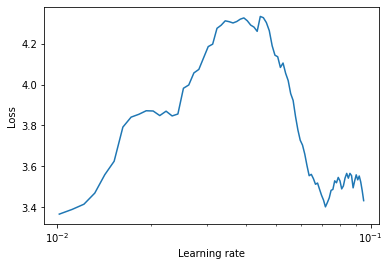

In [25]:
lr_finder = LRScheduler.LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader , end_lr = 0.1, num_iter = 100 , step_mode = "linear")
lr_finder.plot()

In [26]:
history = lr_finder.history
optim_lr = history["lr"][np.argmin(history["loss"])] 
#self.logger.info("Learning rate with minimum loss : " + str(optim_lr))
lr_finder.reset

<bound method LRFinder.reset of <TSAI.S11.LRScheduler.LRFinder object at 0x7f1e827b37f0>>

In [27]:
print(optim_lr)

0.0031272727272727272


horse   cat   cat  deer plane   cat horse  ship  bird  bird  ship   dog plane   car  ship  bird  deer horse horse   dog   car plane  ship  bird plane   dog  deer horse horse   cat  ship   car  frog plane truck   cat horse  ship   cat truck truck horse   dog   cat   dog  frog plane horse  frog  deer  ship plane  ship   dog  bird  ship   car   cat   car  deer truck  ship  deer  deer   car   cat   car  frog   car horse plane horse horse horse   dog  deer   car   car   cat truck horse truck truck plane truck  ship  bird  ship  ship  bird  deer horse plane plane   dog   cat truck  bird  deer truck truck plane horse horse truck  deer plane  deer truck horse plane truck horse  ship horse  deer  ship   cat   car   car   cat horse horse  deer   dog   dog  bird plane   cat  bird  deer horse  bird  frog  deer horse  bird  frog  ship truck   dog horse  ship  frog  ship  deer   dog   car plane plane horse horse   cat horse horse plane plane  frog  ship  frog   cat truck plane   car  bird   cat  shi

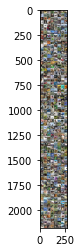

In [12]:
import numpy as np
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = next(iter(trainloader))
images, labels = dataiter

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(512)))

In [13]:
print(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.95,weight_decay = 0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.003,div_factor = 6 ,
                                                cycle_momentum = True , epochs=24, steps_per_epoch = len(trainloader),pct_start= 5/24,final_div_factor=1,anneal_strategy='linear')

cuda


In [14]:
start_time = time.time()
for epoch in range(24):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # print statistics
        running_loss += loss.item()
        if i % 90 == 89:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 89 ))
            running_loss = 0.0

print('Finished Training')
end_time = time.time()
print("Time Taken in Seconds: ",end_time-start_time)

/content/TSAI/S11/CustomResNet.py:57: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


[1,    90] loss: 2.637
[2,    90] loss: 2.204
[3,    90] loss: 2.006
[4,    90] loss: 1.909
[5,    90] loss: 1.836
[6,    90] loss: 1.773
[7,    90] loss: 1.720
[8,    90] loss: 1.673


KeyboardInterrupt: ignored

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

/content/TSAI/S11/CustomResNet.py:57: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy of the network on the 10000 test images: 77 %
